# Exploring Interdisciplinary Connections in Duke Ph.D. Committees
## 2018 Scholars@Duke Visualization Challenge
Matthew Epland  
[matthew.epland@duke.edu](mailto:matthew.epland@duke.edu)

## Setup

In [1]:
# Do imports and display setup
import pandas as pd
import numpy as np
import networkx as nx
from visJS2jupyter import visJS_module
import community
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import math
import os
import operator
from itertools import cycle
from operator import itemgetter
from ast import literal_eval
from datetime import datetime
from textwrap import wrap
import json

# For display purposes
%matplotlib inline
# plt.switch_backend('TkAgg')
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 800)

In [2]:
# Setup paths, global variables
primary_only = False # graph primary appointments only, or also joint and secondary.
output_path = './output/'
debug = False
my_nrows = None # run on all rows

if primary_only:
    edges_path = '../outputs/apt_primary/edges_primary_appointments.csv'
    orgs_path = '../outputs/apt_primary/org_names_primary_appointments.csv'
else:
    edges_path = '../outputs/apt_all/edges_all_appointments.csv'
    orgs_path = '../outputs/apt_all/org_names_all_appointments.csv'
    
color_order=[0,2,4,6,8,10,14,16,18,12,1,3,5,7,9,11,15,17,19,13]

In [3]:
# Define a function to create the output dir, if it already exists don't crash, otherwise raise an exception
# Adapted from A-B-B's response to http://stackoverflow.com/questions/273192/in-python-check-if-a-directory-exists-and-create-it-if-necessary
# Note in python 3.4+ 'os.makedirs(output_path, exist_ok=True)' would handle all of this...
def make_path(path):
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise Exception('Problem creating output dir %s !!!\nA file with the same name probably already exists, please fix the conflict and run again.' % path)

### Define custom color functions for good discrete node colors, min / max edge colors  
It has to be in this string format for visJS2jupyter. See [`return_node_to_color()`](https://github.com/ucsd-ccbb/visJS2jupyter/blob/master/visJS2jupyter/visJS_module.py#L558) and [`return_edge_to_color()`](https://github.com/ucsd-ccbb/visJS2jupyter/blob/master/visJS2jupyter/visJS_module.py#L605) in [visJS_module.py](https://github.com/ucsd-ccbb/visJS2jupyter/blob/master/visJS2jupyter/visJS_module.py) for the normal methods  

In [4]:
def my_node_to_color(G,field_to_map='degree'):
    nodes_with_data = [(n[0], max(n[1][field_to_map], 0)) for n in G.nodes(data=True)]

    cmap_nsteps=20
    if len(color_order)!=cmap_nsteps: print "len(color_order)!=cmap_nsteps, you might have problems!!"
    cmap=plt.get_cmap("tab20")
    alpha = 1.0
    
    color_list_raw = cmap(np.linspace(0, 1, cmap_nsteps)) 
  
    nodes,data = zip(*nodes_with_data)
    data = [color_order[d] for d in data]
    nodes_with_data = zip(nodes,data)

    node_to_mapField = dict(nodes_with_data)
    color_list = [color_list_raw[node_to_mapField[d]] for d in G.nodes()]
    
    color_list = [(int(256*c[0]),int(256*c[1]),int(256*c[2]),alpha) for c in color_list]
    node_to_color = dict(zip(list(G.nodes()),['rgba'+str(c) for c in color_list]))

    return node_to_color

In [5]:
color_max_frac=1.0
color_min_frac=0.15
    
def my_edge_to_color_log_transform(weight, weight_max):
    color_to_mult = color_max_frac-color_min_frac
    color_to_add = color_min_frac
    
    # for cmap, weight scaled to [0, 1], taking the log and acounting for color_max_frac, color_min_frac
    return (np.log(weight)/np.log(weight_max))*color_to_mult + color_to_add
 
def my_edge_to_color(G,field_to_map='weight'):
    cmap=plt.cm.Greys
    alpha=1.0

    G_edges = G.edges(data=True)
    edges_with_data = [(e[0],e[1],e[2][field_to_map]) for e in G_edges]
    edges1,edges2,data = zip(*edges_with_data)

    # turn off some safety code to make it easier to replicate in mpl, should have safe weight values anyway
    # min_dn0 = min(data)
    # data = [np.log(max(d,min_dn0)) for d in data]  # set the zero d values to minimum non0 value
    # data = [(d-np.min(data)) for d in data] # shift so we don't have any negative values

    data = [np.log(d) for d in data]

    G_edges = G.edges()
    edges_with_data = zip(zip(edges1,edges2),data)
 
    color_to_mult = 256*(color_max_frac-color_min_frac)
    color_to_add = 256*color_min_frac

    edge_to_mapField = dict(edges_with_data)
    color_list = [np.multiply(cmap(int((float(edge_to_mapField[d])/np.max(list(edge_to_mapField.values())))*color_to_mult+color_to_add)),256) for d in G_edges]

    color_list = [(int(c[0]),int(c[1]),int(c[2]),alpha) for c in color_list]
    edge_to_color = dict(zip(list(G_edges),['rgba'+str(c) for c in color_list]))

    return edge_to_color

In [6]:
# function to convert visJS2jupyter text colors to regular matplotlib colot tuples
def color_str_to_tuple(color_str):
    color_str = color_str.replace('rgba','')
    color_tuple_raw = literal_eval(color_str)
    color_tuple = [x / 256.0 for x in color_tuple_raw[:3]]
    color_tuple.append(color_tuple_raw[3])
    return color_tuple

In [7]:
# Convert between visJS2jupyter and matplotlib symbol names
visJS_to_mpl_symbol={
'dot':'o',
'square':'s',
'triangleDown':'v',
'triangle':'^',
'diamond':'D',
'star':'*'
}

### Read in human readable organization names, create usable dicts / symbols for them

In [8]:
df_org = pd.read_csv(orgs_path, dtype={'ORGANIZATIONAL_UNIT': int,
                                       'SCHOOL_NAME': object,
                                       'ORG_DISPLAY_NAME': object})

df_org['SCHOOL_NAME'].replace("Institutes and Provost's Academic Units",
                              "Institutes & Provost's Academic Units", True)

df_org_index = df_org.set_index('ORGANIZATIONAL_UNIT')

df_org_names = df_org_index[['ORG_DISPLAY_NAME']]
org_names = df_org_names.to_dict()['ORG_DISPLAY_NAME']

df_school_names = df_org_index[['SCHOOL_NAME']]
school_names = df_school_names.to_dict()['SCHOOL_NAME']

# autogenerate symbol_list
#school_names_list = list(df_org_index['SCHOOL_NAME'].unique())
#symbol_list = ["dot", "diamond", "star", "triangle", "triangleDown", "square"]
#school_symbols = {k: v for k, v in zip(school_names_list, cycle(symbol_list))}

# just hard code to group up smaller schools
school_symbols={
 'Trinity College of Arts & Sciences': 'dot',
 'Pratt School of Engineering': 'square',
 'School of Medicine': 'triangle',
 "Institutes & Provost's Academic Units": 'triangleDown',
 'Nicholas School of the Environment': 'diamond',
 'School of Nursing': 'star',
 'Sanford School of Public Policy': 'star',
 'Divinity School': 'star',
 'Duke Law School': 'star',
 'Fuqua School of Business': 'star',
}

In [9]:
# start creating the school symbol legend
school_leg_order=[
    'Trinity College of Arts & Sciences',
    'School of Medicine',
    "Institutes & Provost's Academic Units",
    'Pratt School of Engineering',
    'Nicholas School of the Environment',
    'Sanford School of Public Policy','Fuqua School of Business','Duke Law School','Divinity School','School of Nursing']
school_leg_objects = []
for school in school_leg_order:
    school_leg_objects.append(plt.Line2D([0],[0],ls='None',marker=visJS_to_mpl_symbol[school_symbols[school]],ms=7.0,label=school,c='black'))

In [10]:
# plot a stand alone school symbol legend
#plt.figure(figsize=(9, 4), dpi=120, facecolor='w', edgecolor='k')
#plt.axis("off")
#school_leg = plt.legend(school_leg_objects, [ob.get_label() for ob in school_leg_objects], fontsize='large', borderaxespad=0.0)
#school_leg.get_frame().set_edgecolor('white')
#school_leg.get_frame().set_facecolor('white')
#plt.show()

## Create and Annotate All Years Graph

In [11]:
# Read in edges from csv
if debug:
    if(my_nrows is not None): print "Reading first %d rows of %s" % (my_nrows, edges_path)
    else: print "Reading all rows of %s" % (edges_path)
# need to specify dtypes manually when reading many rows...
# otherwise pandas wants to try to load all the rows into memory before inferring the dtype and you get a warning
df_edges = pd.read_csv(edges_path, dtype={
'Date': object,
'n1': int,
'n2': int
} , nrows=my_nrows)
df_edges['Date'] = pd.to_datetime(df_edges['Date'],format='%Y-%m-%d')

### Build graph G
#### Construct G explicitly, edge by edge, so the weights are correct. Annotate nodes with the total weights from all their edges

In [12]:
def build_G(df):
    G = nx.Graph()
    default_weight = 1.0
    for index, row in df.iterrows():
        n1 = row['n1']
        n2 = row['n2']
        if G.has_edge(n1,n2):
            G[n1][n2]['weight'] += default_weight
        else:
            G.add_edge(n1,n2, weight=default_weight)

    total_weight_dict = {}
    for node in G.nodes():
        total_weight = 0.0
        for edge in G.edges(node,data=True):
            total_weight += edge[2]['weight']
        total_weight_dict[node] = total_weight
    
    nx.set_node_attributes(G, name='total_weight', values=total_weight_dict)

    return G

# now actually create graph from all years
G_all = build_G(df_edges)

### Create positions using the Fruchterman-Reingold force-directed / spring algorithm

In [13]:
# k=1/sqrt(n) is the default spring / spacing parameter
# Increase max iterations to 100, just in case it needs it
# Need to install networkx from master to access new random_state parameter
# Sets the random seed and allows for reproducable layouts across runs
spring_pos = nx.spring_layout(G_all,
                              k=4/math.sqrt(nx.number_of_nodes(G_all)),
                              iterations=100,
                              random_state=5)

### Create communities using the Louvain Method

In [14]:
# The resolution parameter affects the size of the returned communities
# Best results found with resolution=1, the default unmodified Louvain Method
communities = community.best_partition(G_all, weight='weight', resolution=1)

nx.set_node_attributes(G_all, name='communities', values=communities)
node_to_color = my_node_to_color(G_all,field_to_map='communities')

In [15]:
# Setup useful G_all variables
nodes_all = G_all.nodes()

nodes_to_shape = {}
for n in nodes_all:
    nodes_to_shape[n] = school_symbols[school_names[n]]
nx.set_node_attributes(G_all, name='symbol', values=nodes_to_shape)

edge_to_color_all = my_edge_to_color(G_all)

## List members of the communities in nice color coded tables

In [16]:
community_names = {
    0:'"School of Medicine"',
    1:'Neuro',
    2:'Physical Sciences',
    3:'Social Science / Health, Pro Schools',
    4:'Liberal Arts',
    5:'Bio / Evolution'
}

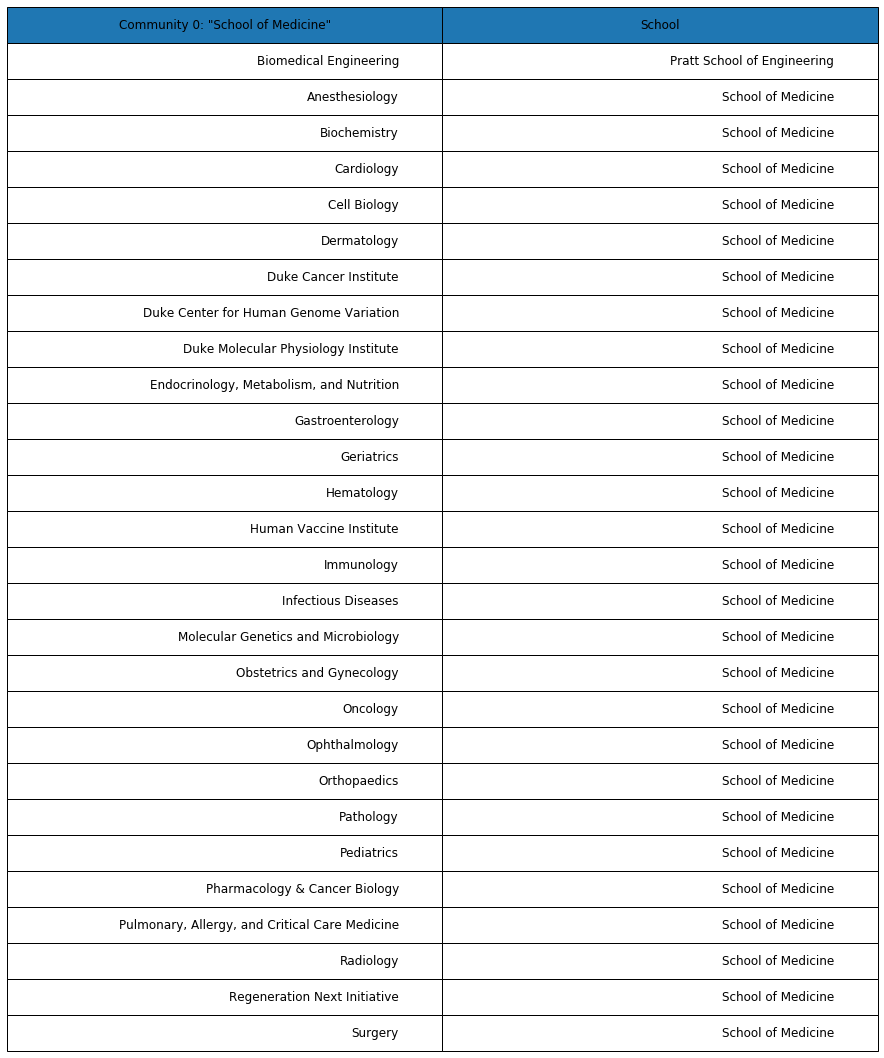

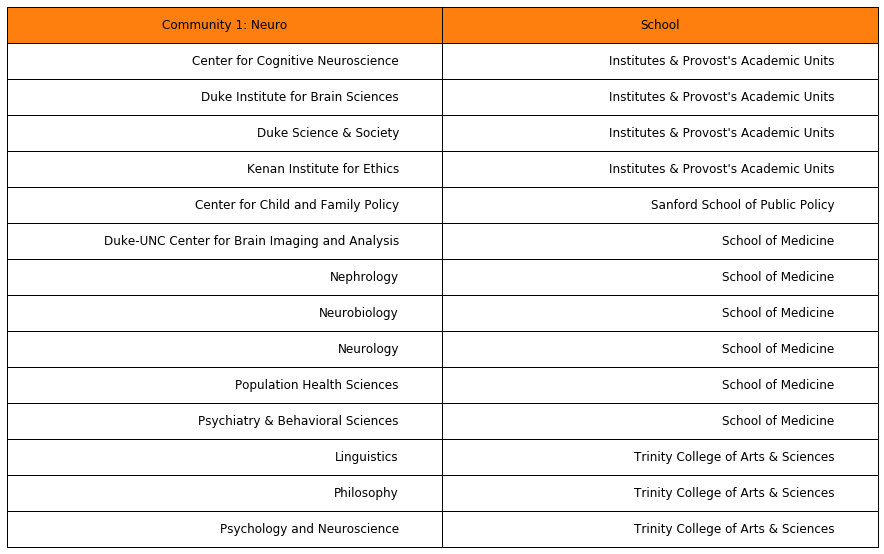

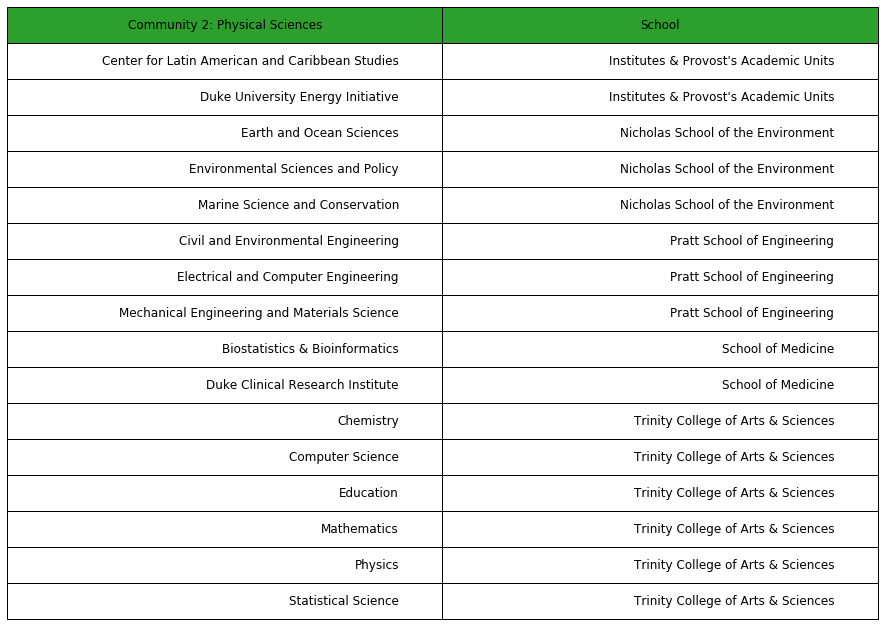

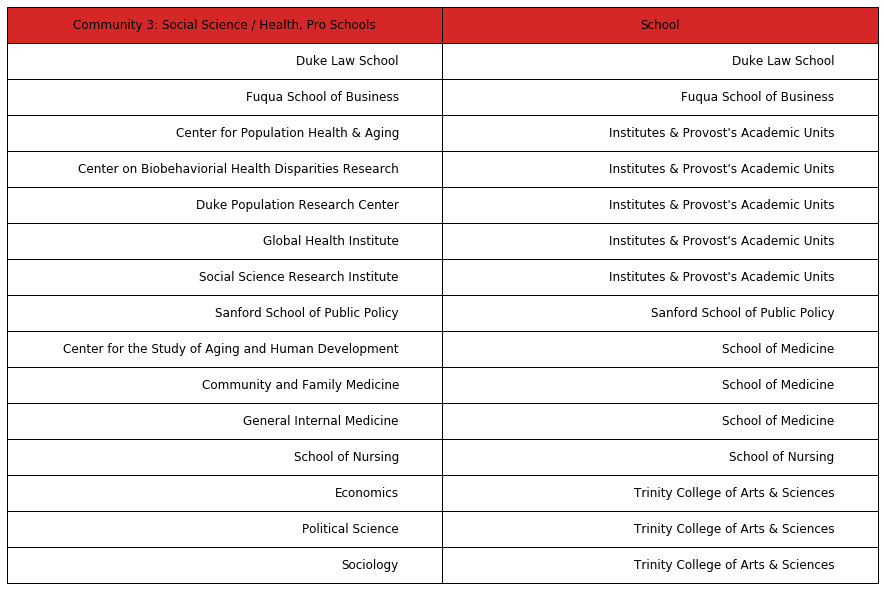

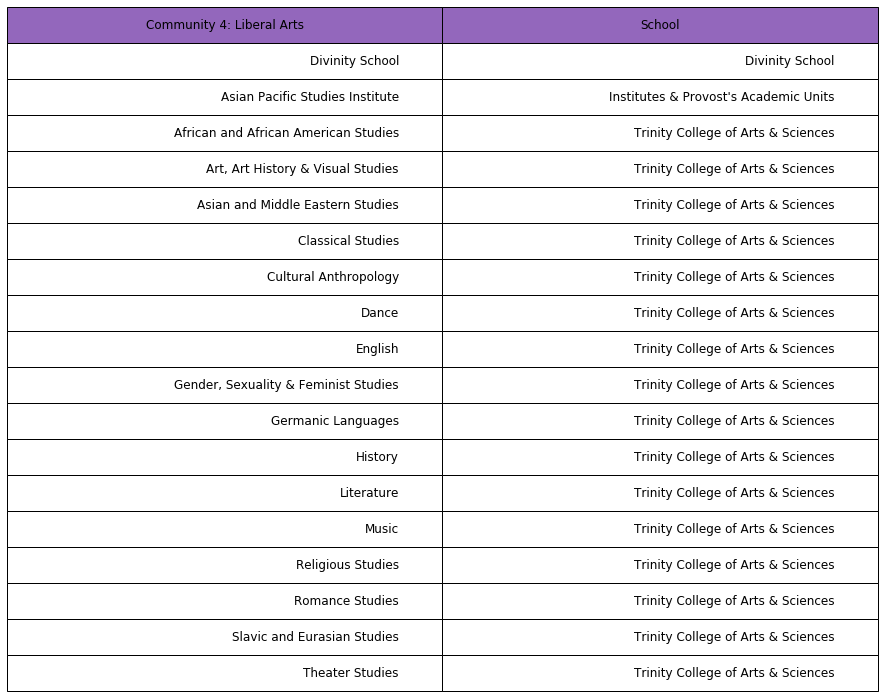

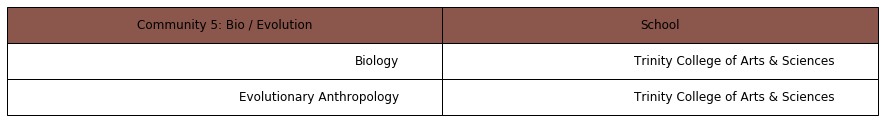

In [17]:
community_colors = {}

df_communities = pd.DataFrame(communities.items(), columns=['ORGANIZATIONAL_UNIT', 'Community'])

for community in sorted(df_communities.Community.unique()):
    df_community = df_communities[df_communities['Community']==community]

    cell_text = [] # eventual text of the table
    first_n = -1 # used to get the correct color
    for n in list(df_community['ORGANIZATIONAL_UNIT']):
        cell_text.append([org_names[n], school_names[n]])
        if first_n == -1: first_n = n

    cell_text.sort(key = operator.itemgetter(1, 0))

    community_colors[community]=color_str_to_tuple(node_to_color[first_n])
    
    filename = ("community_%d_%s" % (community,community_names[community]))
    safe_filename = filename.replace(" ", "_").replace("'", "").replace("\"", "").replace("&", "and").replace("/", "slash").replace(",", "")

    colLabels=[("Community %d: %s" % (community,community_names[community])),"School"]

    nrows, ncols = len(cell_text)+1, len(colLabels)
    hcell, wcell = 0.1, 2.5 # tweak to fit
    hpad, wpad = 0.2, 0.2
    
    fig = plt.figure(safe_filename, figsize=(ncols*wcell+wpad, nrows*hcell+hpad))
    ax = fig.add_subplot(111)
    ax.axis('off')
    the_table = ax.table(cellText=cell_text,
                         colLabels=colLabels,
                         colColours=[community_colors[community],community_colors[community]],
                         loc='center')
    the_table.scale(3,3)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)

    plt.show()
    
    make_path(output_path+"community_members/")
    fig.savefig(output_path+"community_members/"+safe_filename+".pdf", format="pdf", bbox_inches='tight')
    fig.clf()

## Plot static graphs

In [18]:
def plot_graph(this_G,display_annotations=True,label_text="",show_plot=False,m_path=None,filename=None):
    figname = "graph"
    if filename is not None: figname += '_'+filename
    fig = plt.figure(figname)
    fig.set_size_inches(13, 8) # x, y inches

    if display_annotations:
        gs = gridspec.GridSpec(1,2, width_ratios=[2.8, 1])
        ax_left = plt.subplot(gs[0])
    else:
        ax_left = plt.subplot(111)
    ax_left.axis("off")
    ax_left.margins(0,0)

    # draw edges
    this_edge_to_color = my_edge_to_color(this_G)
    
    # all at once
    #nx.draw_networkx_edges(this_G,spring_pos,ax=ax_left,width=4,edge_color=[color_str_to_tuple(this_edge_to_color[e]) for e in list(this_G.edges())])

    # by weight, smallest to largest, binned by edge_bin_size. This makes the graph much more readable
    edge_bin_size=20
    edges=this_G.edges(data=True)
    edge_weight_class_ordering=sorted(set([math.ceil(edge[2]['weight']/edge_bin_size) for edge in edges]))
    for weight_class in edge_weight_class_ordering:        
        edges_to_draw=[edge for edge in edges if math.ceil(edge[2]['weight']/edge_bin_size)==weight_class]
        nx.draw_networkx_edges(this_G,spring_pos,edgelist=edges_to_draw,ax=ax_left,width=4,edge_color=[color_str_to_tuple(this_edge_to_color[(e[0],e[1])]) for e in edges_to_draw])

    # draw nodes
    # have to do a call per symbol due to networkx limitations, so we can't really draw in order of weight
    for shape in set((shape[1]["symbol"] for shape in this_G.nodes(data = True))):
        node_list = [node[0] for node in filter(lambda x: x[1]["symbol"]==shape,this_G.nodes(data = True))]
        nx.draw_networkx_nodes(this_G, ax=ax_left, pos=spring_pos, nodelist=node_list,
                               node_color=[color_str_to_tuple(node_to_color[n]) for n in node_list],
                               node_size=[20*math.log(this_G.node[n]['total_weight']) for n in node_list],
                               node_shape=visJS_to_mpl_symbol[shape]
                              )

    if display_annotations:
        ax_right = plt.subplot(gs[1])
        ax_right.axis("off")
        ax_right.margins(0,0)

        # school legend
        school_leg = plt.legend(school_leg_objects, [ob.get_label() for ob in school_leg_objects], fontsize='large',
                                bbox_to_anchor=(-0.2,0.95), loc='upper left', borderaxespad=0.0)
        school_leg.set_title("Schools",prop={'size':'large','weight':'bold'})
        school_leg._legend_box.align = "left"
        school_leg.get_frame().set_edgecolor('white')
        school_leg.get_frame().set_facecolor('white')
        
        # community legend
        community_leg_objects=[]
        for n in range(len(community_names)):
             community_leg_objects.append(plt.Line2D([0],[0],marker='s',ls='none',markersize=13,
                                                     label=community_names[n],
                                                     color=community_colors[n]))
        community_leg = plt.legend(community_leg_objects, [ob.get_label() for ob in community_leg_objects], fontsize='large',
                                   bbox_to_anchor=(-0.2,0.5615), loc='upper left', borderaxespad=0.0)
        community_leg.set_title("Louvain Communities",prop={'size':'large','weight':'bold'})
        community_leg._legend_box.align = "left"
        community_leg.get_frame().set_edgecolor('white')
        community_leg.get_frame().set_facecolor('white')

        plt.gca().add_artist(school_leg)

        # text annotations
        plt.figtext(0.851, 0.164, "Node Size $\sim$ log(Total Weight)", size='large', ha='center', fontweight='bold')
        
        if label_text is not None:        
            plt.figtext(0.851, 0.946, label_text, size='large', ha='center', fontweight='bold')

        # edge weight colorbar cb1
        edge_weights = [e[2]['weight'] for e in this_G.edges(data=True)]
        if min(edge_weights) != 1.0: "min edge weight != 1, edge color scale might be off..."
        edge_weight_max = int(max(edge_weights))
        
        cb1_source_tick_labels = [1, 10, 100, 500, 2000, 10000] 
        cb1_tick_labels=[]
        nsource=0
        while cb1_source_tick_labels[nsource] < edge_weight_max:
            cb1_tick_labels.append(cb1_source_tick_labels[nsource])
            nsource += 1

        cb1_tick_labels.append(edge_weight_max)        
        cb1_ticks=[my_edge_to_color_log_transform(l,edge_weight_max) for l in cb1_tick_labels]
    
        cax = fig.add_axes([0.718, 0.272, 0.245, 0.045])
        cmap = plt.cm.Greys
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal',ticks=cb1_ticks)
        cb1.set_label('Edge Weight', fontsize='large',weight='bold')
        cb1.ax.set_xticklabels(cb1_tick_labels)

    # write it out!
    fig.tight_layout()
    if (m_path is not None) and (filename is not None):
        make_path(m_path)
        fig.savefig(m_path+filename+'.pdf', format="pdf")

    if show_plot:
        plt.show()
        
    fig.clf()

### Print graph of all years

/home/mepland/.virtualenvs/pandas/lib/python2.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


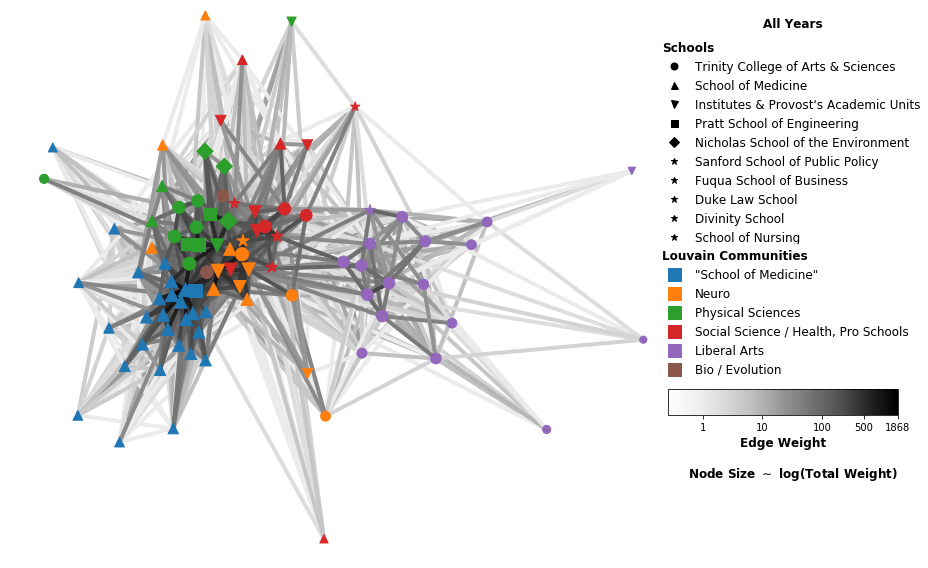

In [19]:
date_min_all = min(df_edges.Date).strftime('%Y-%m-%d')
date_max_all = max(df_edges.Date).strftime('%Y-%m-%d')
# all_date_str = ("All (%s to %s)" % (date_min_all, date_max_all))
all_date_str = "All Years"

# plot_graph(G_all,False,None,False,output_path,"network_all")
plot_graph(G_all,True,all_date_str,True,output_path,"network_all_annotated")

## Start date binned results

In [20]:
print "Date min: %s" % (min(df_edges.Date))
print "Date max: %s" % (max(df_edges.Date))

date_bins = ['2012-5-1', '2013-8-26','2014-8-25','2015-8-24','2016-8-29','2017-10-1']
print "Date binning:"
print date_bins

Date min: 2012-05-13 00:00:00
Date max: 2017-09-01 00:00:00
Date binning:
['2012-5-1', '2013-8-26', '2014-8-25', '2015-8-24', '2016-8-29', '2017-10-1']


In [21]:
# create G_binned list of graphs per year, with metadata
G_binned = []
year_ints = []

# have to do the all years entry on its own first
G_total_weight_all = 0
for e in G_all.edges(data=True):
    G_total_weight_all += e[2]['weight']
G_node_weights_all=[G_all.node[n]['total_weight'] for n in G_all.nodes()]
G_node_weight_q75_all, G_node_weight_q25_all = np.percentile(G_node_weights_all, [75 ,25])

G_weight_mean_all = float(G_total_weight_all)/float(nx.number_of_nodes(G_all))
G_node_weight_median_all = np.median(G_node_weights_all)
G_node_weight_iqr_all = G_node_weight_q75_all - G_node_weight_q25_all
 
G_binned.append([G_all,date_min_all,date_max_all,G_total_weight_all,G_weight_mean_all,G_node_weight_median_all,G_node_weight_iqr_all])
year_ints.append(-1) # denote all years by -1

# do the rest in a loop
for nbin in range(len(date_bins)-1):
    date_min = date_bins[nbin]
    date_max = date_bins[nbin+1]

    df_edges_bin = df_edges.loc[(date_min <= df_edges['Date']) & (df_edges['Date'] < date_max)]

    # print "For %s to %s, N rows used = %d" % (date_min, date_max, len(df_edges_bin.index))
    
    G_bin = build_G(df_edges_bin)
    
    communities_bin = {}
    for node in G_bin.nodes(): communities_bin[node]=communities[node]
    nx.set_node_attributes(G_bin, name='communities', values=communities_bin)

    nodes_to_shape_bin = {}
    for node in G_bin.nodes(): nodes_to_shape_bin[node]=nodes_to_shape[node]
    nx.set_node_attributes(G_bin, name='symbol', values=nodes_to_shape_bin)

    G_total_weight = 0
    for e in G_bin.edges(data=True):
        G_total_weight += e[2]['weight']

    G_node_weights=[G_bin.node[n]['total_weight'] for n in G_bin.nodes()]
    G_node_weight_q75, G_node_weight_q25 = np.percentile(G_node_weights, [75 ,25])

    G_weight_mean = float(G_total_weight)/float(nx.number_of_nodes(G_bin))
    G_node_weight_median = np.median(G_node_weights)
    G_node_weight_iqr = G_node_weight_q75 - G_node_weight_q25
  
    G_binned.append([G_bin,date_min,date_max,G_total_weight,G_weight_mean,G_node_weight_median,G_node_weight_iqr])
    year_ints.append(datetime.strptime(date_bins[nbin+1], '%Y-%m-%d').year)

all_years_value = sorted(year_ints)[1]-1

#### Print out graphs for each year

In [22]:
for nbin in range(len(G_binned)):
    date_min = G_binned[nbin][1]
    date_max = G_binned[nbin][2]
    if year_ints[nbin] != -1: year_str = str(year_ints[nbin])
    else: year_str = 'All'
    date_str = ("%s (%s to %s)" % (year_str, date_min, date_max))
    plot_graph(G_binned[nbin][0],True,date_str,False,output_path+"time_binned_networks/","network_"+year_str)

### Display Statistics, Centrality Measures, and Graph by Year

In [23]:
def text_info_and_graph(nbin):
    this_G = G_binned[nbin][0]
    date_min = G_binned[nbin][1]
    date_max = G_binned[nbin][2]
    if year_ints[nbin] != -1: year_str = str(year_ints[nbin])
    else: year_str = 'All'
    date_str = ("%s (%s to %s)" % (year_str, date_min, date_max))
    
    print date_str 
    print "\nNumber of nodes: %d" % nx.number_of_nodes(this_G)
    print "Number of edges: %d" % nx.number_of_edges(this_G)
    print "Total weight: %d" % G_binned[nbin][3]

    print "\nDensity: %.4f" % (nx.density(this_G))
    print "Triadic closure: %.4f" % (nx.transitivity(this_G))
    print "Diameter: %d" % (nx.diameter(this_G))
    
    degree_dict = dict(this_G.degree(this_G.nodes()))
    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print "\nTop 5% of nodes by degree:"
    for d in sorted_degree[:int(0.05*len(sorted_degree))]:
        print "%d, %s - %s" % (d[1], org_names[d[0]], school_names[d[0]])
        
    eigenvector_dict = nx.eigenvector_centrality(this_G)
    sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)
    print "\nTop 5% of nodes by eigenvector:"
    for d in sorted_eigenvector[:int(0.05*len(sorted_eigenvector))]:
        print "%.4f, %s - %s" % (d[1], org_names[d[0]], school_names[d[0]])
        
    betweenness_dict = nx.betweenness_centrality(this_G)
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
    print "\nTop 5% of nodes by betweenness:"
    for d in sorted_betweenness[:int(0.05*len(sorted_betweenness))]:
        print "%.4f, %s - %s" % (d[1], org_names[d[0]], school_names[d[0]])
        
    plot_graph(this_G,True,date_str,True)

In [24]:
interact(text_info_and_graph, nbin=widgets.IntSlider(description='Time Bin:',min=0,max=len(G_binned)-1,step=1,value=0));

interactive(children=(IntSlider(value=0, description=u'Time Bin:', max=5), Output()), _dom_classes=('widget-interact',))

## Interdisciplinary Fraction Calculations

### Actually compute the interdisciplinary fractions, save them to a new dataframe

In [25]:
all_rows_list = []
for nbin in range(len(G_binned)):
    this_G = G_binned[nbin][0]
    year = year_ints[nbin]
    
    G_total_weight = G_binned[nbin][3]
    G_weight_mean =  G_binned[nbin][4]
    G_node_weight_median =  G_binned[nbin][5]
    G_node_weight_iqr =  G_binned[nbin][6]

    for node in this_G.nodes():
        node_interdis_weight = 0.0
        node_total_weight = 0.0
        
        # while we are looping over edges, also find the maximum weight edge
        max_edge_weight = 0.0
        max_edge = []
        for edge in this_G.edges(node,data=True):
            weight = edge[2]['weight']
            node_total_weight += weight
            if edge[0] != edge[1]: # this is an external edge
                node_interdis_weight += weight
            if weight > max_edge_weight: # We are not too concerned about ties so this is fine...
                max_edge_weight = weight
                max_edge = [edge[0], edge[1]]

        max_edge.remove(node)      

        this_row = {'year':year,
                    'node':node,
                    'org_name':org_names[node],
                    'school_name':school_names[node],
                    'community':communities[node],
                    'interdis_frac':float(node_interdis_weight)/float(node_total_weight),
                    'node_total_weight':node_total_weight,
                    'node_max_edge':max_edge[0],
                    'node_max_edge_weight':max_edge_weight,
                    'G_total_weight':G_total_weight,
                    'G_weight_mean':G_weight_mean,
                    'G_node_weight_median':G_node_weight_median,
                    'G_node_weight_iqr':G_node_weight_iqr
                   }
        all_rows_list.append(this_row)

df_fracs = pd.DataFrame(all_rows_list)

In [26]:
# Create fraction and max edge annotation dicts for all years graph, will later be used in interactive plot
interdis_frac_dict_all = {}
max_edge_dict_all = {}
max_edge_weight_dict_all = {}
df_fracs_all = df_fracs[(df_fracs.year == -1)]
if len(df_fracs_all.index) != len(df_fracs_all.node.unique()): print "ERROR repeat nodes!!"
for index, row in df_fracs_all.iterrows():
    interdis_frac_dict_all[row['node']]=row['interdis_frac']
    max_edge_dict_all[row['node']]=row['node_max_edge']
    max_edge_weight_dict_all[row['node']]=row['node_max_edge_weight']

### Remove low statistics organizations per year

In [27]:
# df_fracs['cut'] = df_fracs.G_node_weight_median - 0.3*df_fracs.G_node_weight_iqr
df_fracs['cut'] = 100
df_fracs = df_fracs[(df_fracs.cut < df_fracs.node_total_weight)]            

### Create the interdisciplinary fraction plots

In [28]:
# setup plotting variables
frac_plots_path = output_path+"interdis_frac/"

# top n orgs by total weight on node, over all years
top_n_orgs_to_plot = 10

# groupings to plot
communities_to_plot=[0,1,2,3,4,5]
schools_to_plot=['Trinity College of Arts & Sciences','School of Medicine',"Institutes & Provost's Academic Units"]

# setup color list
cmap_nsteps=20
if len(color_order)!=cmap_nsteps: print "len(color_order)!=cmap_nsteps, you might have problems!!"
cmap=plt.get_cmap("tab20")
color_list_raw = cmap(np.linspace(0, 1, cmap_nsteps)) 
color_list = [color_list_raw[color_order[n]] for n in range(cmap_nsteps)]

# setup line style list
ls_list = [(0, ()), (0, (1, 5)), (0, (1, 1)), (0, (5, 10)), (0, (5, 5)), (0, (5, 1)), (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))]

# error checking
if len(color_list) < top_n_orgs_to_plot or len(ls_list) < top_n_orgs_to_plot:
    print "A plot attribute list is to short, plotting will crash!" # could cycle here, but there'd be overcrowding - rather just crash and re-evaluate procedure

In [29]:
# Generate the plot component data (metadata, x,y) for the provided list of organizations
def gen_plot_components(orgs_to_plot,df):
    plot_components = []
    for norg in range(len(orgs_to_plot)):
        org = orgs_to_plot[norg]
        df_org = df[(df.org_name == org)]

        real_schools = df_org.school_name.unique()
        if len(real_schools) > 1: print "ERROR: Multiple real_schools, continuing!"; continue
        real_school = real_schools[0]

        xaxis_values = []
        yaxis_values = []
        for year in year_ints:
            df_org_year = df_org[(df_org.year == year)]
            if df_org_year.empty:
                # print "Empty df_org_year, continuing!"
                continue
            elif len(df_org_year.index)!=1:
                print "> 1 rows in df_org_year - something is wrong! Continuing!"
                continue
            else:
                if year != -1: xaxis_values.append(year)
                else: xaxis_values.append(all_years_value)
                yaxis_values.append(df_org_year.interdis_frac.iloc[0])
   
            # print df_org_year[['year','interdis_frac','org_name','node_total_weight','cut','G_node_weight_iqr']]

        # save out org if it has enough years, >=3, not counting All
        real_years_passing_cut = list(xaxis_values)
        if all_years_value in real_years_passing_cut: real_years_passing_cut.remove(all_years_value)
        if len(real_years_passing_cut) >= 3:
            plot_components.append([org,xaxis_values,yaxis_values,real_school])

    return plot_components

In [30]:
# Actually plot the interdisciplinary fractions
def plot_frac(title,m_path,plot_components,title_color='none'):
    safe_title = title.replace(" ", "_").replace("'", "").replace("\"", "").replace("&", "and").replace("/", "slash").replace(",", "")
    fig = plt.figure("frac_plot "+safe_title)
    fig.set_size_inches(13, 7) # x, y inches
    gs = gridspec.GridSpec(1, 2, width_ratios=[2.8, 1]) 
    ax_left = plt.subplot(gs[0])
    ax_left.margins(0,0)
    
    # clean up the axis ticks, linewidth, etc
    ax_left.tick_params(axis='x', which='both', direction='in', bottom=True, top=True, labelbottom='on', labeltop='off',length=8,width=1.3)
    ax_left.tick_params(axis='y', which='both', direction='in', left=True, right=True, labelleft='on', labelright='off',length=8,width=1.3)
    ax_left.set_xlabel('Year', fontsize=14)
    ax_left.set_ylabel('Interdisciplinary Fraction', fontsize=14)
    ax_left.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax_left.tick_params(axis='both', which='major', labelsize=13)
    ax_left.yaxis.labelpad = 9
    for axis in ['top','bottom','left','right']:
        ax_left.spines[axis].set_linewidth(1.3)
    
    # plot each org
    frac_leg_objects = []
    for nplot in range(len(plot_components)):
        plot_label = plot_components[nplot][0]
        xaxis_values = plot_components[nplot][1]
        yaxis_values = plot_components[nplot][2]
        school = plot_components[nplot][3]
        plot = ax_left.plot(xaxis_values,yaxis_values,
                                label=plot_label,
                                color=color_list[nplot],
                                linestyle=ls_list[nplot],
                                marker=visJS_to_mpl_symbol[school_symbols[school]],
                                linewidth=3,
                                markersize=10)
        frac_leg_objects.append(plot[0])
        
    # Clean up x axis tick values, ie change all years tick label to 'All'
    ticklocs = ax_left.xaxis.get_ticklocs()
    tickmin = min(ticklocs)
    tickmax = max(ticklocs)    
    ticklabels = []
    for tick in list(ticklocs):
        if tick == all_years_value: ticklabels.append('All')
        # elif tick == tickmin: ticklabels.append('')
        # elif tick == tickmax: ticklabels.append('')
        else: ticklabels.append('%d' % tick)
    plt.xticks(ticklocs, ticklabels)

    # adjust y axis range
    xmin, xmax, ymin, ymax = ax_left.axis()
    # new_ymin = min(0.8, ymin - 0.1*(1.0 - ymin))
    new_ymin = ymin - 0.1*(1.0 - ymin)
    ax_left.set_ylim(new_ymin, 1.0)
    ax_left.set_xlim(xmin-0.5, xmax+0.5)

    # legend and annotation
    ax_right = plt.subplot(gs[1])
    ax_right.axis("off")
    ax_right.margins(0,0)

    frac_leg = plt.legend(frac_leg_objects, [ '\n'.join(wrap(ob.get_label(), 35)) for ob in frac_leg_objects],
                         fontsize='large',
                         bbox_to_anchor=(-0.2,0.95), loc='upper left', borderaxespad=0.0)
    frac_leg.get_frame().set_edgecolor('white')
    frac_leg.get_frame().set_facecolor('white')

    ann_text = "%s" % (title)
    plt.figtext(0.851, 0.946, ann_text, size='large', ha='center', fontweight='bold',
                bbox=dict(facecolor='none', edgecolor=title_color, linewidth=3))
    
    # save out
    fig.tight_layout()
    make_path(m_path)
    fig.savefig(m_path+safe_title+".pdf", format="pdf")
    plt.show()
    fig.clf()

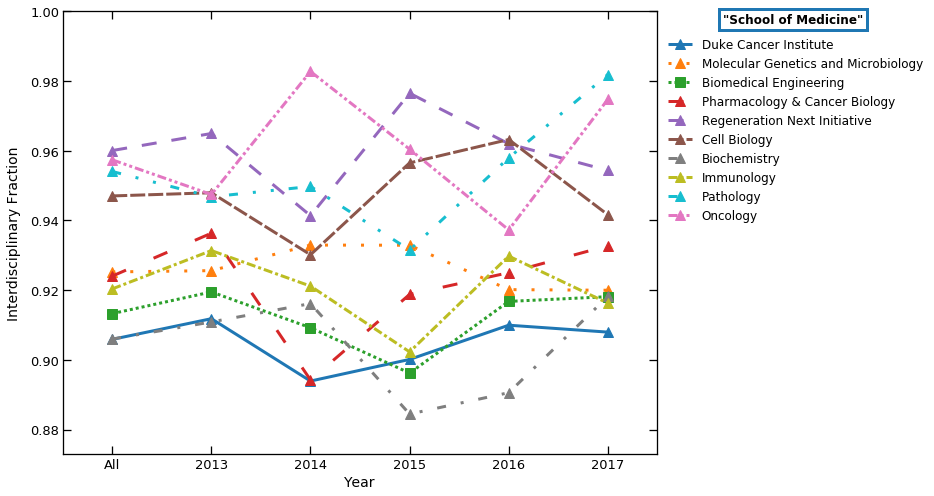

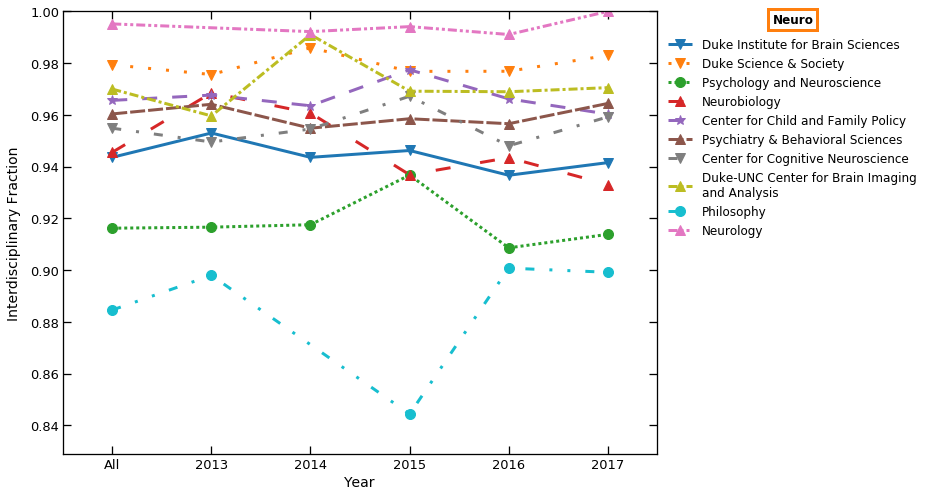

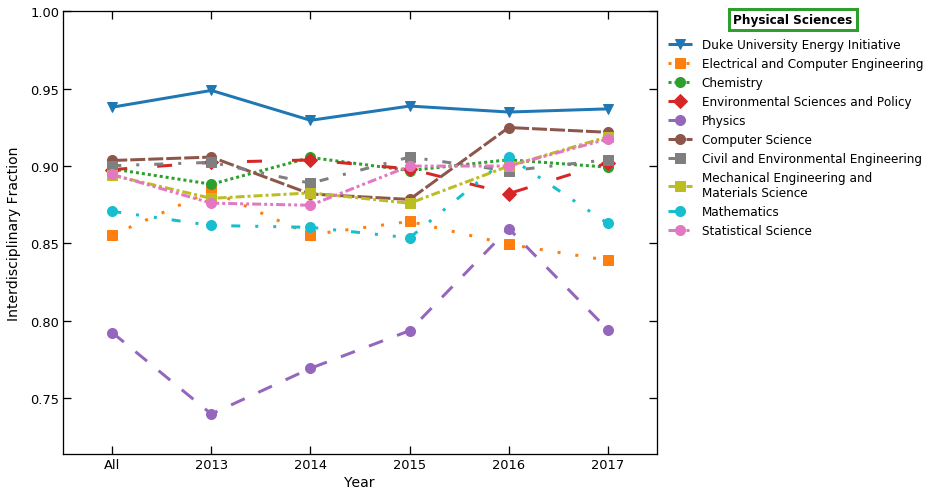

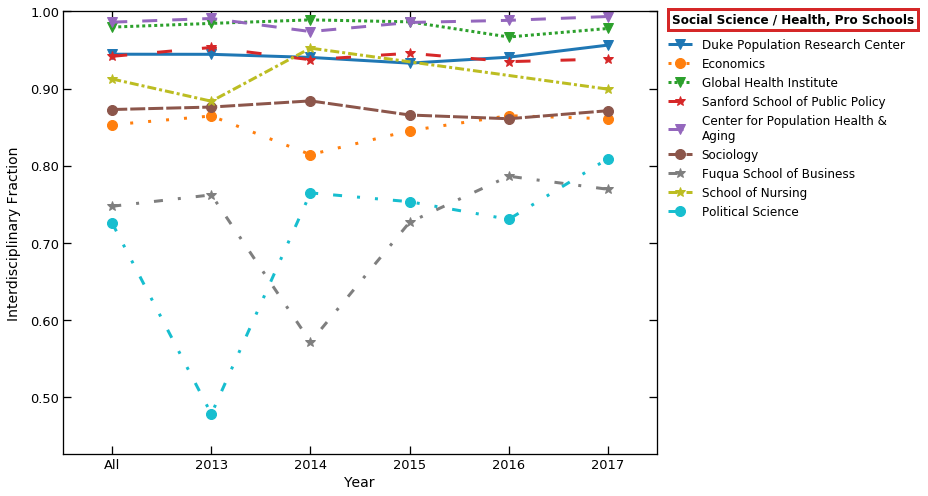

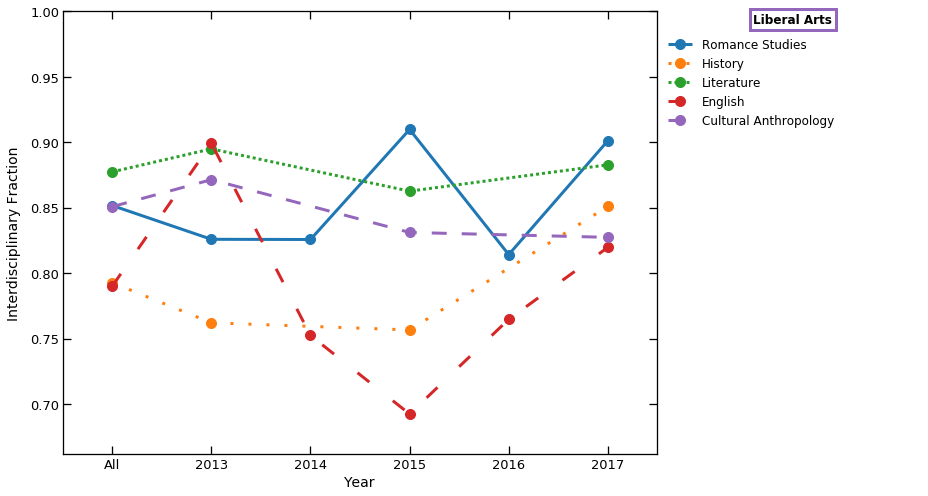

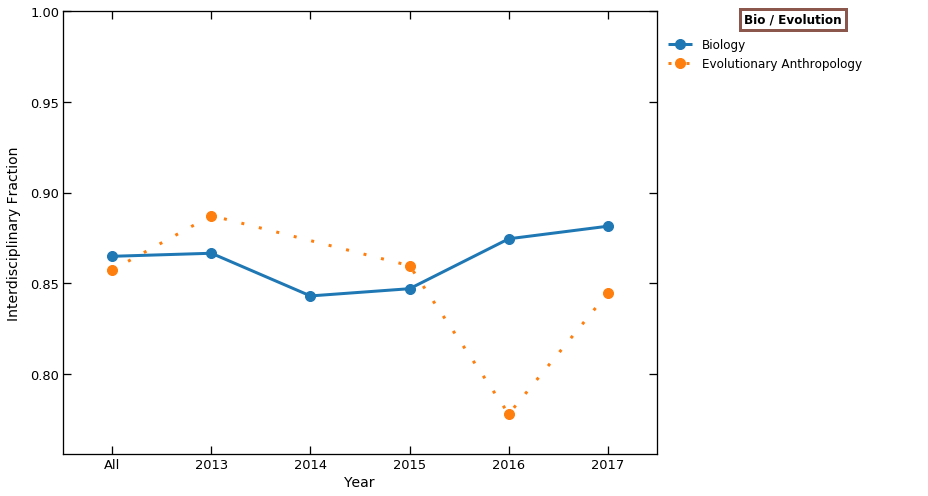

In [31]:
# plot interdisciplinary fraction by community
for community in communities_to_plot:
    # Get the correct community dataframe
    df_community = df_fracs[(df_fracs.community == community)]
    if df_community.empty: print "No rows in df_community, continuing!"; continue;

    # Find orgs to plot
    df_community_all = df_community[(df_community.year == -1)]
    if df_community_all.empty: print "No rows in df_community_all, continuing!"; continue;
    orgs_to_plot = df_community_all.nlargest(top_n_orgs_to_plot, 'node_total_weight').org_name.unique()

    # generate components and plot them
    plot_components = gen_plot_components(orgs_to_plot,df_community)
    plot_frac(community_names[community],frac_plots_path+"communities/",plot_components,community_colors[community])        

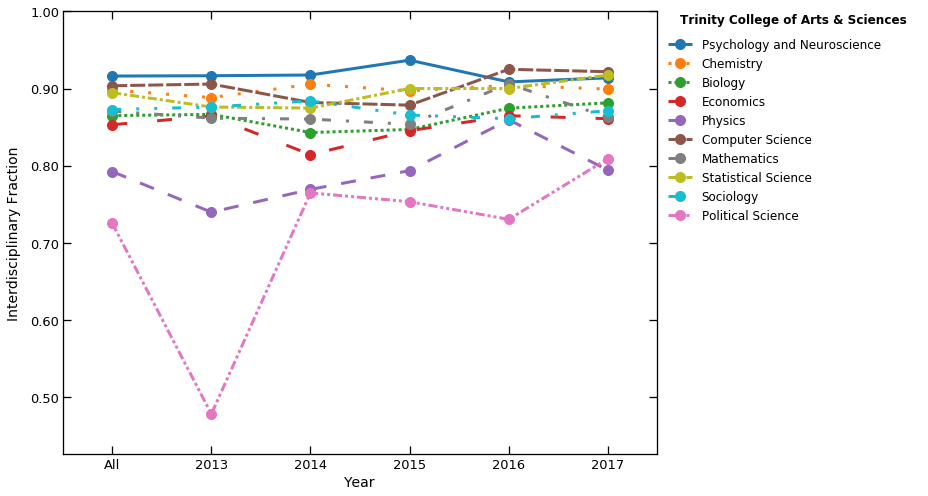

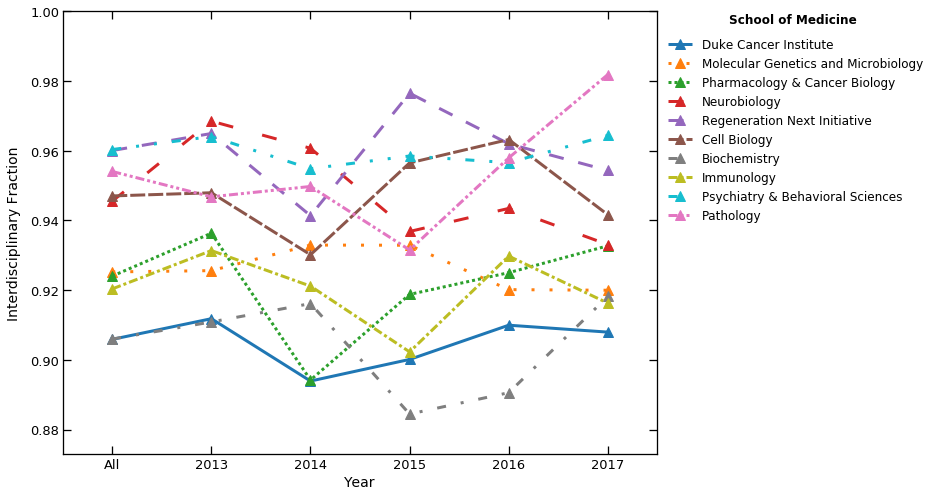

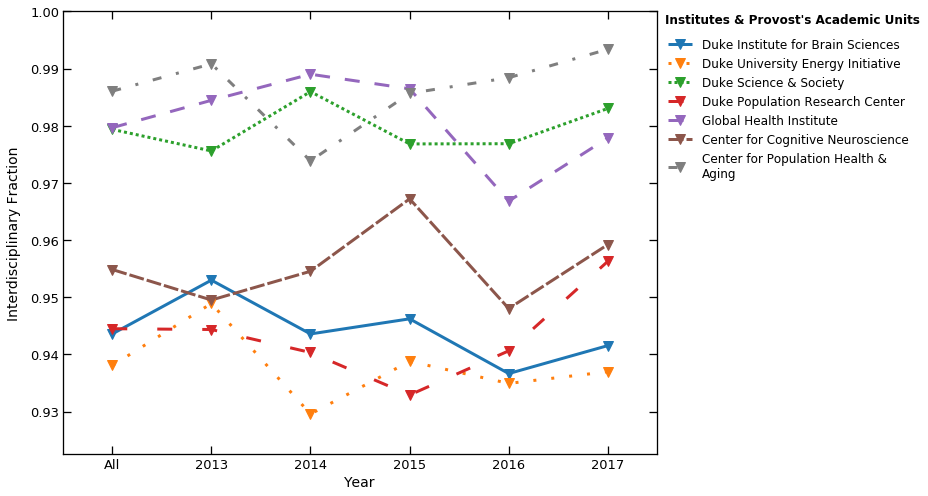

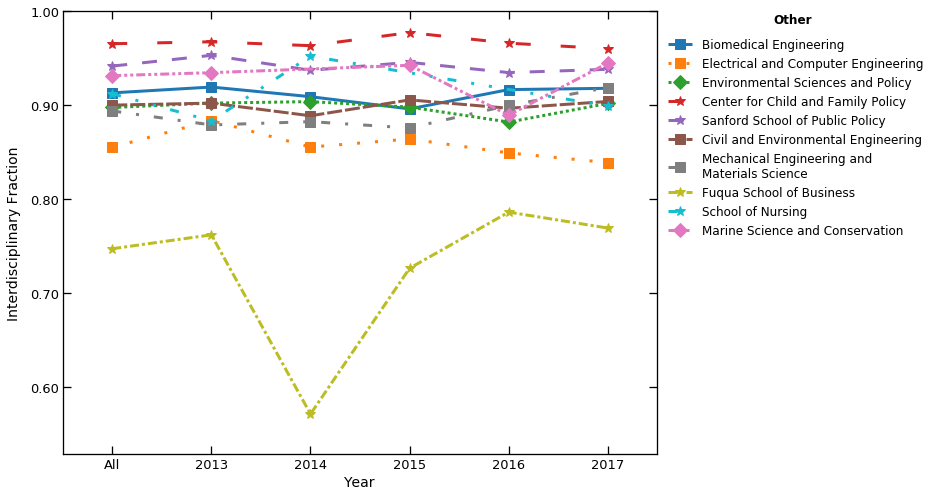

In [32]:
# plot interdisciplinary fraction by school
for school in schools_to_plot+['Other']:
    # Get the correct school dataframe
    if school != 'Other':
        df_school = df_fracs[(df_fracs.school_name == school)]
    else:
        df_school = df_fracs
        for school2 in schools_to_plot:
            df_school = df_school[(df_school.school_name != school2)]

    if df_school.empty: print "No rows in df_school, continuing!"; continue;

    # Find orgs to plot
    df_school_all = df_school[(df_school.year == -1)]
    if df_school_all.empty: print "No rows in df_school_all, continuing!"; continue;
    orgs_to_plot = df_school_all.nlargest(top_n_orgs_to_plot, 'node_total_weight').org_name.unique()

    # generate components and plot them
    plot_components = gen_plot_components(orgs_to_plot,df_school)
    plot_frac(school,frac_plots_path+"schools/",plot_components)        

## Draw interactive all years graph!

In [33]:
# create nodes_dict
nx.set_node_attributes(G_all, name='interdis_frac', values=interdis_frac_dict_all)
nx.set_node_attributes(G_all, name='max_edge', values=max_edge_dict_all)
nx.set_node_attributes(G_all, name='max_edge_weight', values=max_edge_weight_dict_all)

nodes_dict = [{"id":n,
               "title":("<center><b>%s</b><br>%s<br>%s<br>Largest Edge: %s, %d<br>Node Weight: %d<br>Interdis Frac: %.3f</center>" % (
                   org_names[n],
                   school_names[n],
                   community_names[communities[n]],
                   org_names[G_all.node[n]['max_edge']],
                   G_all.node[n]['max_edge_weight'],
                   G_all.node[n]['total_weight'],
                   G_all.node[n]['interdis_frac']
                   )),
               "x":spring_pos[n][0]*1000,
               "y":(1-spring_pos[n][1])*1000,
               "color":node_to_color[n], 
               "node_shape":G_all.node[n]['symbol'],
               "node_size":G_all.node[n]['total_weight']
              } for n in nodes_all]
node_map = dict(zip(nodes_all,range(len(nodes_all)))) # map to indices for source/target in edges

In [34]:
# create edges_dict
edges_dict = [{"source":node_map[e[0]],
               "target":node_map[e[1]],
               "title":("<center>n1: %s<br>n2: %s<br>Edge Weight: %d</center" % (
                   org_names[e[0]],
                   org_names[e[1]],
                   e[2]['weight']
               )),
               "color":edge_to_color_all[(e[0],e[1])] 
              }for e in G_all.edges(data=True)]

In [35]:
# save the dicts for later viewing
with open(output_path+'nodes.json', 'w') as fp:
    json.dump(nodes_dict, fp, sort_keys=True, indent=2)

with open(output_path+'edges.json', 'w') as fp:
    json.dump(edges_dict, fp, sort_keys=True, indent=2)

In [36]:
visJS_module.visjs_network(nodes_dict, edges_dict,
                           node_size_field='node_size', node_size_transform='Math.log', node_size_multiplier=2,
                           node_font_size=0,
                           edge_width=9, edge_title_field="title",
                           physics_enabled=False,
                           graph_title="Interactive Duke Interdisciplinary Connections (All Years)",
                           graph_width = 940, graph_height = 600, border_color='black',
                           tooltip_delay = 0, graph_id = 0, config_enabled=False)